# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tableone import TableOne
import torch
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization

from synthcity.metrics.plots import plot_tsne
from synthcity.metrics.eval import Metrics
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
aids_control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
aids_control = pd.read_csv(data_file_control, header=None, names=aids_control_fnames)
print(aids_control.head())

   time  censor  strat2  sex  raceth  ivdrug  karnof    cd4  priorzdv  age
0   189       0       1    1       1       0     100  169.0      39.0   34
1   287       0       1    2       2       0      90  149.5      15.0   34
2   199       0       1    1       1       0      90   46.0      53.0   48
3   270       0       1    1       2       0     100   54.5       6.0   51
4   276       0       1    1       1       0     100   95.0       7.0   34


In [4]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [5]:
# Split the control set into train and test set
n_control_samples = data_init_control.shape[0]
split = int(n_control_samples * 0.8)
indices = torch.randperm(n_control_samples)
train_idx, test_idx = indices[:split], indices[split:]

data_init_control_train = data_init_control[train_idx]
data_init_control_test = data_init_control[test_idx]

In [6]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=aids_control_fnames)
df_init_control_train = pd.DataFrame(data_init_control_train.numpy(), columns=aids_control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=aids_control_fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control_train["treatment"] = 0
df_init = pd.concat([df_init_control_train, df_init_treated], ignore_index=True)

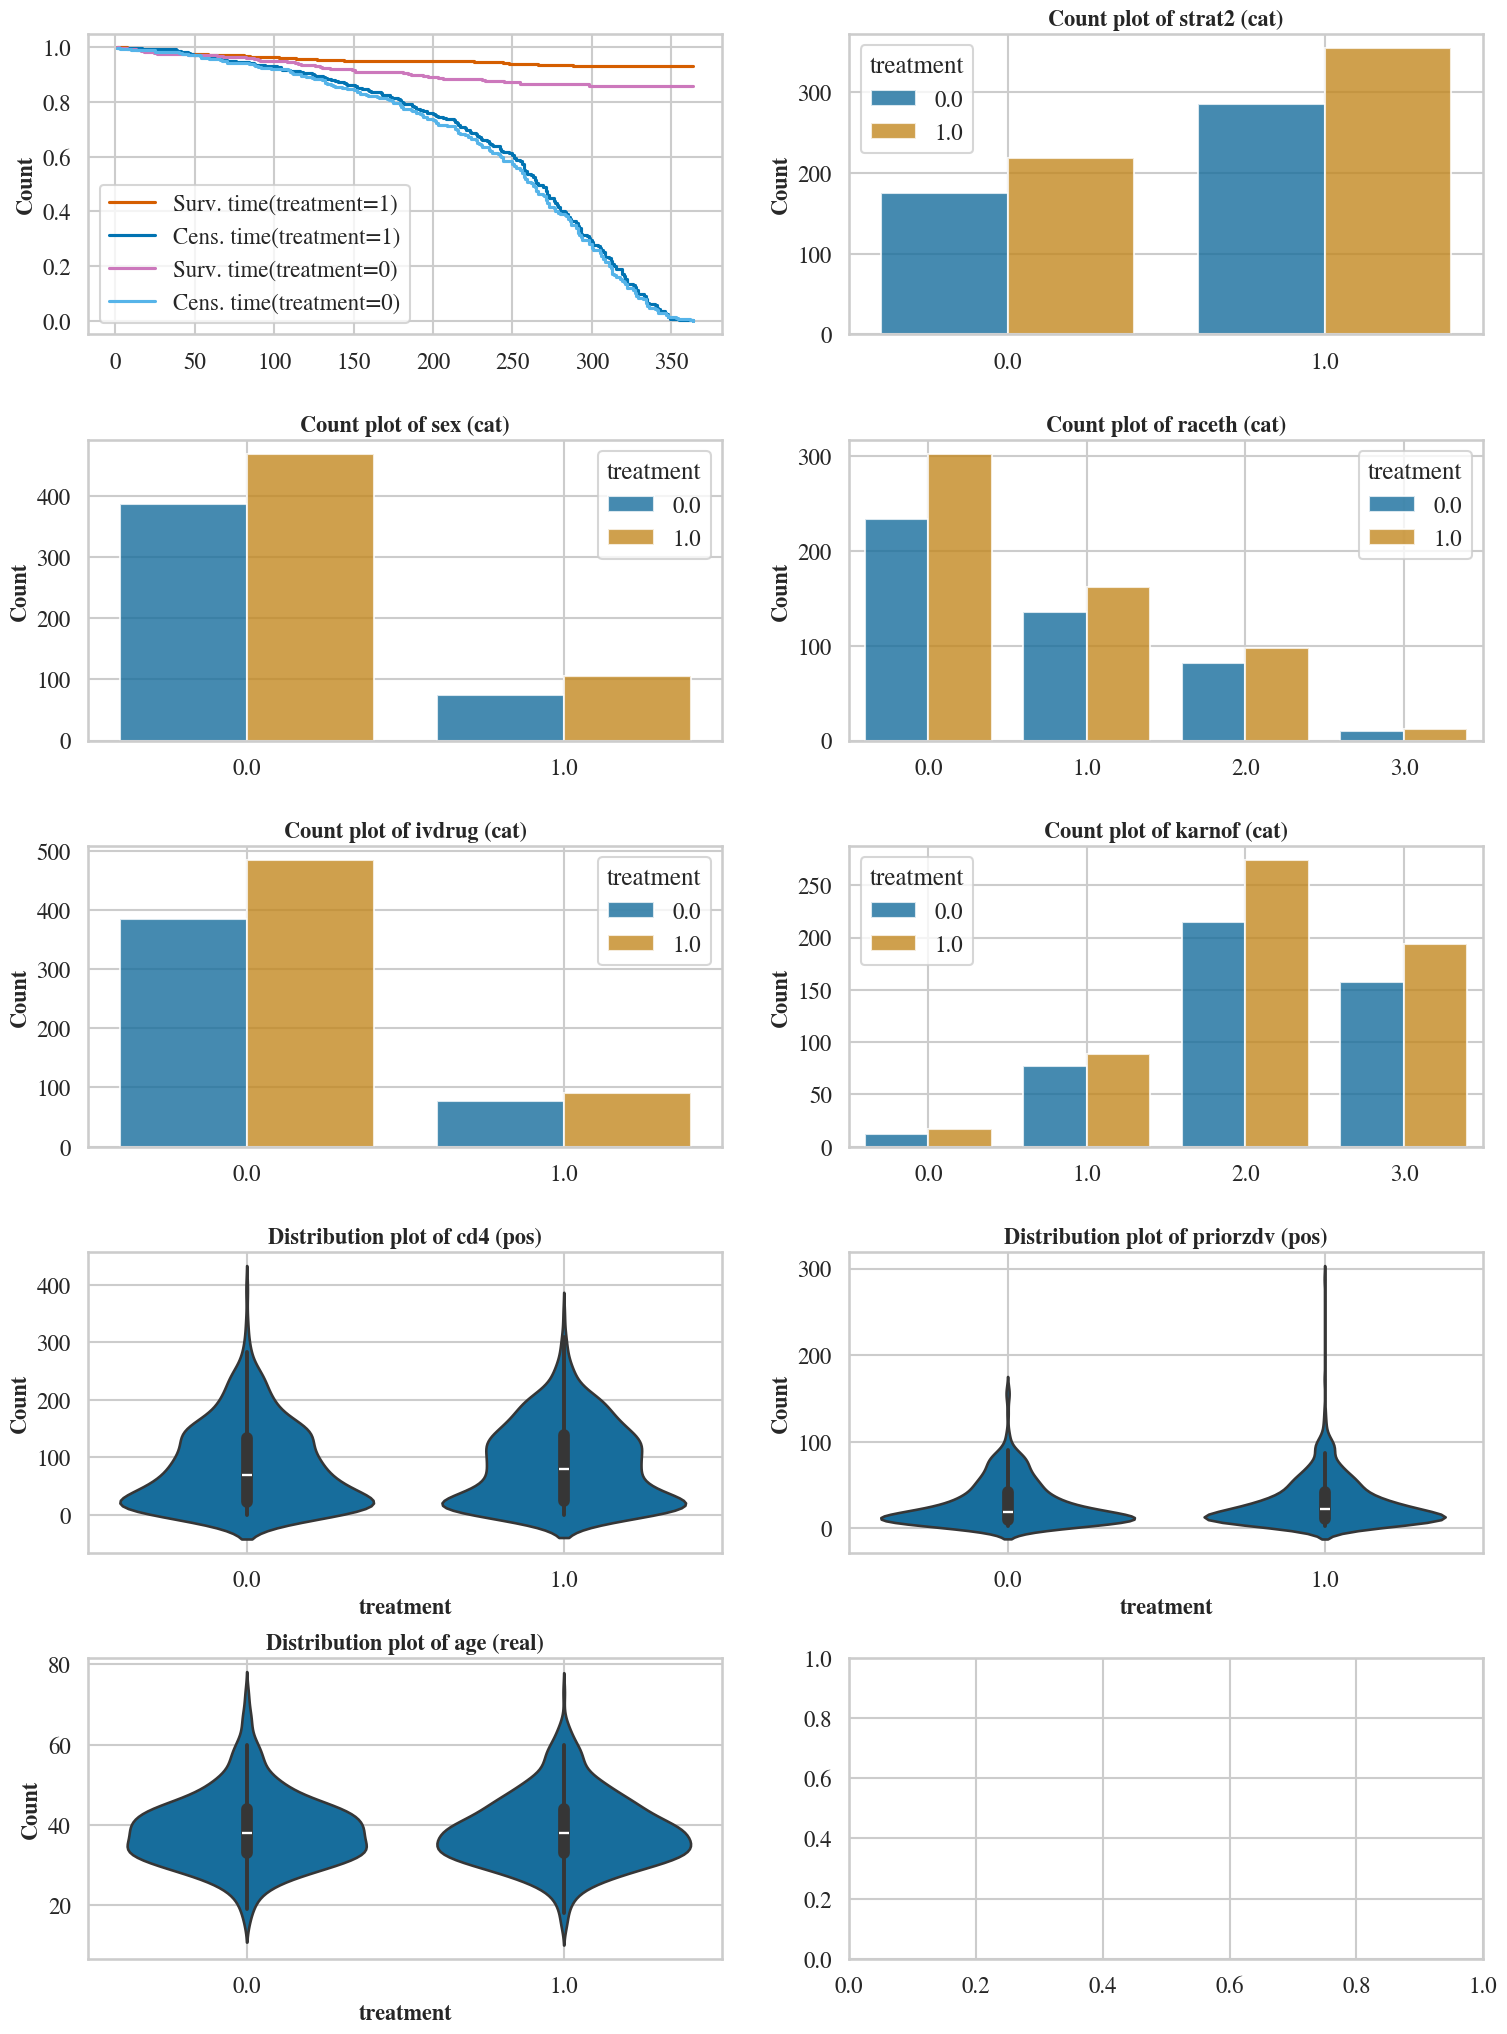

In [7]:
# TODO: Refactor
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [8]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4', 'priorzdv', 'age']
nonnormal = ['time', 'cd4', 'priorzdv']

table1 = TableOne(df_init, categorical=categorical, continuous=continuous, 
                  groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1035                  461                  574        
time, median [Q1,Q3]                            0  257.0 [176.5,300.5]  251.0 [160.0,298.0]  263.0 [187.0,305.0]   0.022
censor, n (%)            0.0                                949 (91.7)           408 (88.5)           541 (94.3)   0.001
                         1.0                                  86 (8.3)            53 (11.5)             33 (5.7)        
strat2, n (%)            0.0                                394 (38.1)           175 (38.0)           219 (38.2)   1.000
                         1.0                                641 (61.9)           286 (62.0)           355 (61.8)        
sex, n (%)               0.0    

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [9]:
from execute import surv_hivae

# the datasets used for training is data_init_control
n_generated_dataset = 100
T_surv = torch.Tensor(df_init_control_train.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [10]:
data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), 
                                  miss_mask_control, true_miss_mask_control, 
                                  feat_types_file_control, feat_types_dict, 
                                  n_generated_dataset, n_generated_sample=data_init_control_test.shape[0])

Epoch: [ 0]  time: 0.0924, ELBO_train: -20.88920937, KL_z: 1.27217469, KL_s: 0.10613208, reconstruction loss: -19.51090260
Epoch: [100]  time: 2.6845, ELBO_train: -17.29850273, KL_z: 0.67291431, KL_s: 0.03775086, reconstruction loss: -16.58783755
Epoch: [200]  time: 5.1751, ELBO_train: -17.12526817, KL_z: 0.75491443, KL_s: 0.02873068, reconstruction loss: -16.34162307
Epoch: [300]  time: 7.8114, ELBO_train: -17.09723778, KL_z: 0.86427444, KL_s: 0.02863955, reconstruction loss: -16.20432378
Epoch: [400]  time: 10.4214, ELBO_train: -17.18382339, KL_z: 0.96880114, KL_s: 0.03012276, reconstruction loss: -16.18489950
Training finished.


## 3. Analyze the generated data

### 3.1. Statistical analysis: one generated control group vs. initial control data

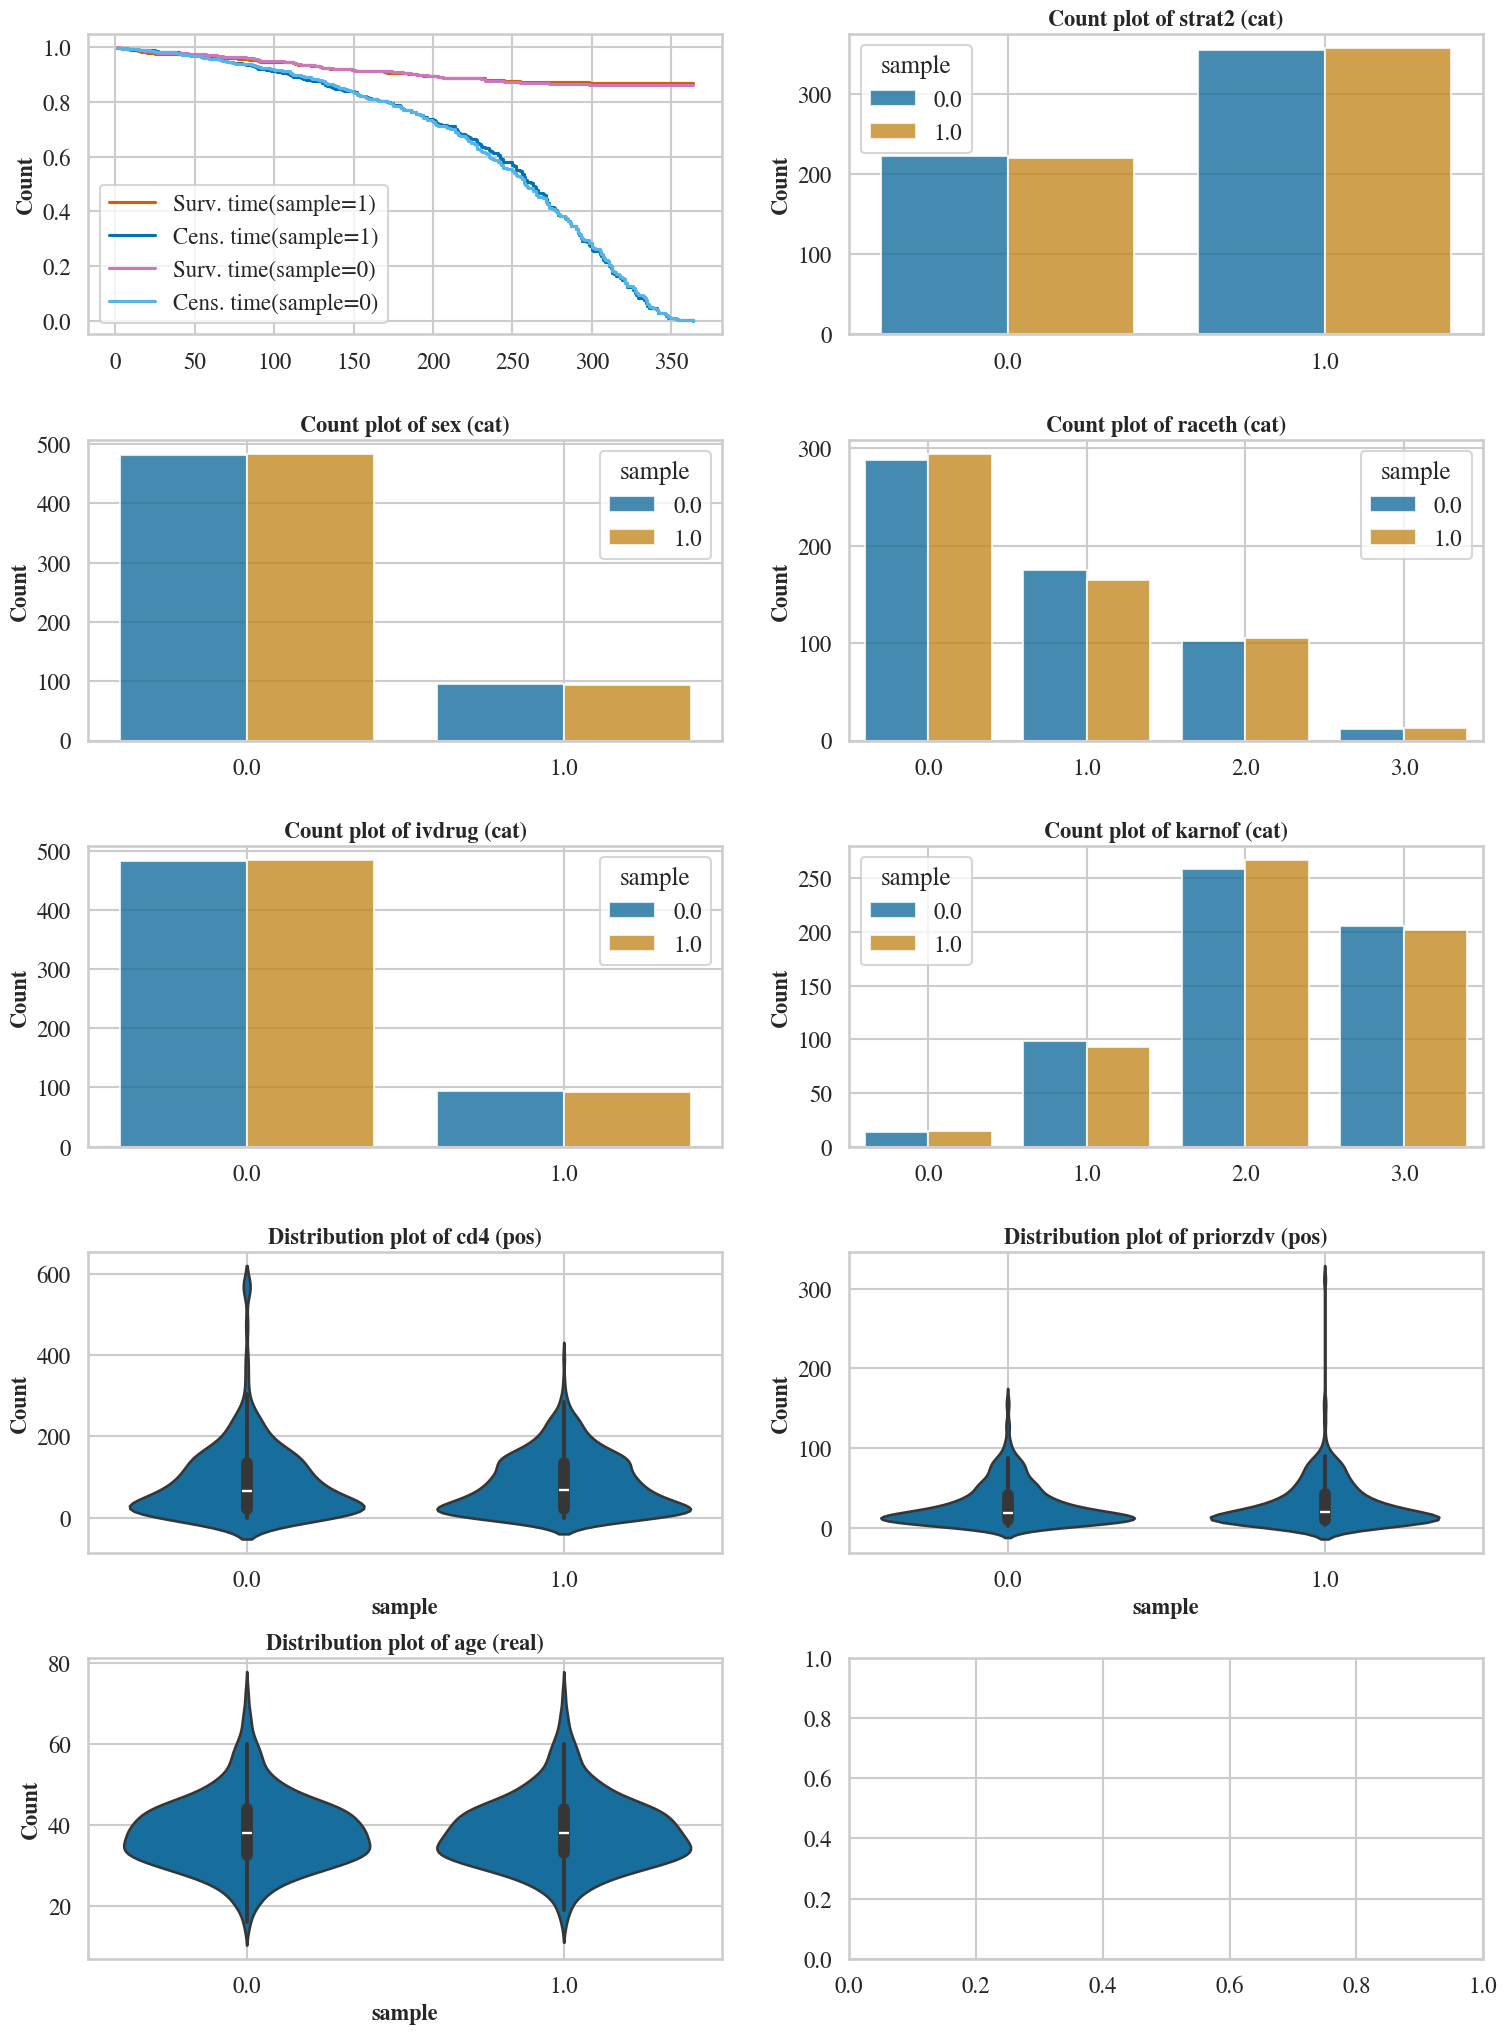

In [11]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=aids_control_fnames)
df_init_control_ext['sample'] = 1

sel_idx = 2
df_gen_control_ext_sel = pd.DataFrame(torch.cat([data_init_control_train, data_gen_control[sel_idx]]).numpy(), columns=aids_control_fnames)
df_gen_control_ext_sel['sample'] = 0

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [12]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','sample']
continuous = ['time', 'cd4', 'priorzdv', 'age']
nonnormal = ['time', 'cd4', 'priorzdv']
table1 = TableOne(df_control_sel, categorical=categorical, continuous=continuous, groupby='sample', nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                       
                                       Missing              Overall                    0                    1 P-Value
n                                                              1154                  577                  577        
time, median [Q1,Q3]                         0  245.0 [158.0,298.0]  243.4 [157.2,298.0]  251.0 [158.0,298.0]   0.884
censor, n (%)            0.0                            1026 (88.9)           512 (88.7)           514 (89.1)   0.925
                         1.0                             128 (11.1)            65 (11.3)            63 (10.9)        
strat2, n (%)            0.0                             442 (38.3)           222 (38.5)           220 (38.1)   0.952
                         1.0                             712 (61.7)           355 (61.5)           357 (61.9)        
sex, n (%)               0.0                            

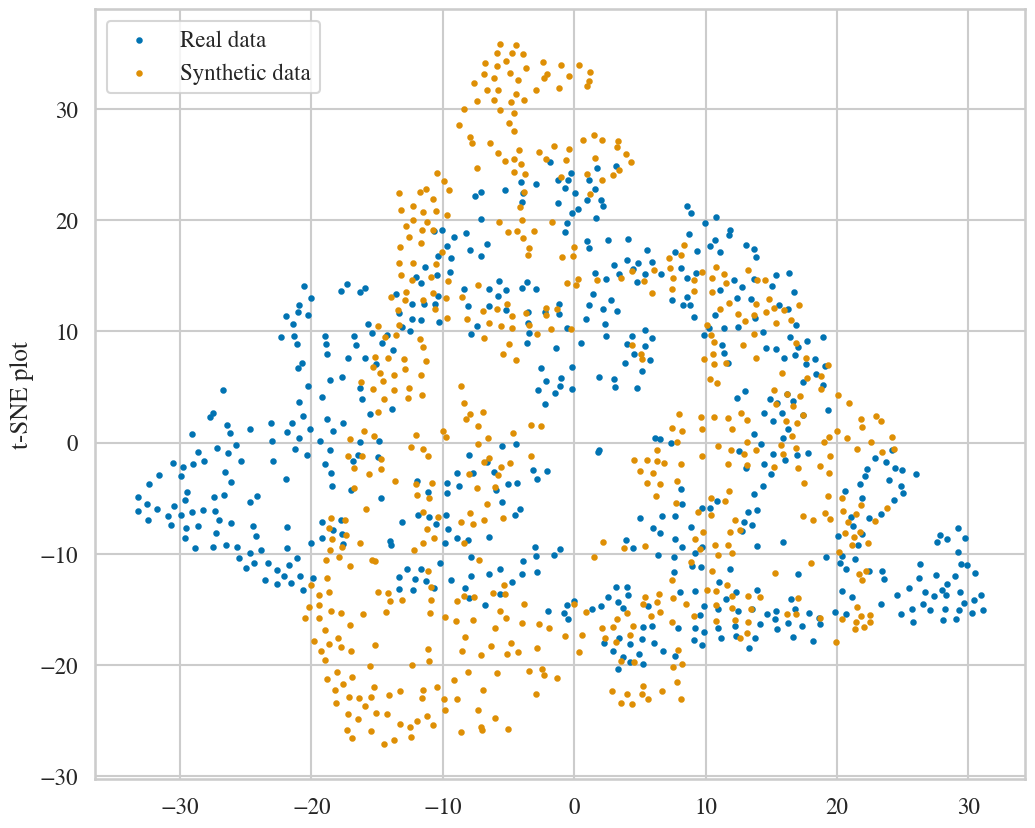

In [13]:
synthcity_dataloader_init = SurvivalAnalysisDataLoader(df_init_control, target_column = "censor", time_to_event_column = "time")
synthcity_dataloader_syn = SurvivalAnalysisDataLoader(df_gen_control_ext_sel, target_column = "censor", time_to_event_column = "time")
plot_tsne(plt, synthcity_dataloader_init, synthcity_dataloader_syn)

### 3.2. Statistical analysis: one generated control group vs. initial treated data

In [14]:
list_df_gen_control = []
for j in range(n_generated_dataset):
    df_gen_control_j = pd.DataFrame(torch.cat([data_init_control_train, data_gen_control[j]]).numpy(), columns=aids_control_fnames)
    df_gen_control_j['treatment'] = 0
    list_df_gen_control.append(df_gen_control_j)

sel_idx = 0
df_gen_control_sel = list_df_gen_control[sel_idx]
df_syn_sel = pd.concat([df_init_treated, df_gen_control_sel], ignore_index=True)

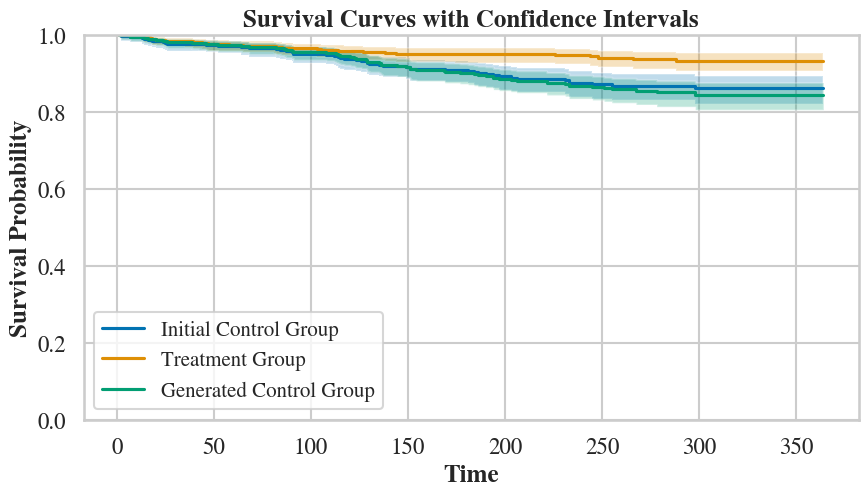

In [15]:
surv_time_control_init = df_init[df_init['treatment']==0].to_numpy()[:,0]
surv_ind_control_init = df_init[df_init['treatment']==0].to_numpy()[:,1].astype(bool)
surv_time_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,0]
surv_ind_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,1].astype(bool)
surv_time_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,0]
surv_ind_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,1].astype(bool)

uniq_time_control_init, surv_prob_control_init, conf_int_control_init = kaplan_meier_estimator(surv_ind_control_init, surv_time_control_init, conf_type="log-log")
uniq_time_treated_init, surv_prob_treated_init, conf_int_treated_init = kaplan_meier_estimator(surv_ind_treated_init, surv_time_treated_init, conf_type="log-log")
uniq_time_control_gen, surv_prob_control_gen, conf_int_control_gen = kaplan_meier_estimator(surv_ind_control_gen, surv_time_control_gen, conf_type="log-log")

plt.figure(figsize=(10, 5))
plt.step(uniq_time_control_init, surv_prob_control_init, where="post", label="Initial Control Group")
plt.fill_between(uniq_time_control_init, conf_int_control_init[0], conf_int_control_init[1], alpha=0.25, step="post")

plt.step(uniq_time_treated_init, surv_prob_treated_init, where="post", label="Treatment Group")
plt.fill_between(uniq_time_treated_init, conf_int_treated_init[0], conf_int_treated_init[1], alpha=0.25, step="post")

plt.step(uniq_time_control_gen, surv_prob_control_gen, where="post", label="Generated Control Group")
plt.fill_between(uniq_time_control_gen, conf_int_control_gen[0], conf_int_control_gen[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.xlabel("Time", fontweight="semibold")
plt.ylabel("Survival Probability", fontweight="semibold")
plt.title("Survival Curves with Confidence Intervals", fontweight="bold")
plt.show()

In [16]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4', 'priorzdv', 'age']
nonnormal = ['time', 'cd4', 'priorzdv']
table1 = TableOne(df_syn_sel, categorical=categorical, continuous=continuous, groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  256.0 [175.0,300.0]  245.0 [160.0,294.0]  263.0 [187.0,305.0]   0.006
censor, n (%)            0.0                               1046 (90.9)           505 (87.5)           541 (94.3)  <0.001
                         1.0                                 105 (9.1)            72 (12.5)             33 (5.7)        
strat2, n (%)            0.0                                441 (38.3)           222 (38.5)           219 (38.2)   0.959
                         1.0                                710 (61.7)           355 (61.5)           355 (61.8)        
sex, n (%)               0.0    

## 4. Testing

### 4.1. Univariate testing

In [18]:
from utils.metrics import log_rank, cox_estimation

data_syn = []
for i in range(n_generated_dataset):
    df_gen_control = pd.DataFrame(torch.cat([data_init_control_train, data_gen_control[i]]).numpy(), columns=aids_control_fnames)
    df_gen_control['treatment'] = 0
    data_syn.append(pd.concat([df_init_treated, df_gen_control], ignore_index=True))

LR_init, LR_syn = log_rank(df_init, data_syn)
coef_init, coef_syn, cox_p_value_init, cox_p_value_syn = cox_estimation(df_init, data_syn)

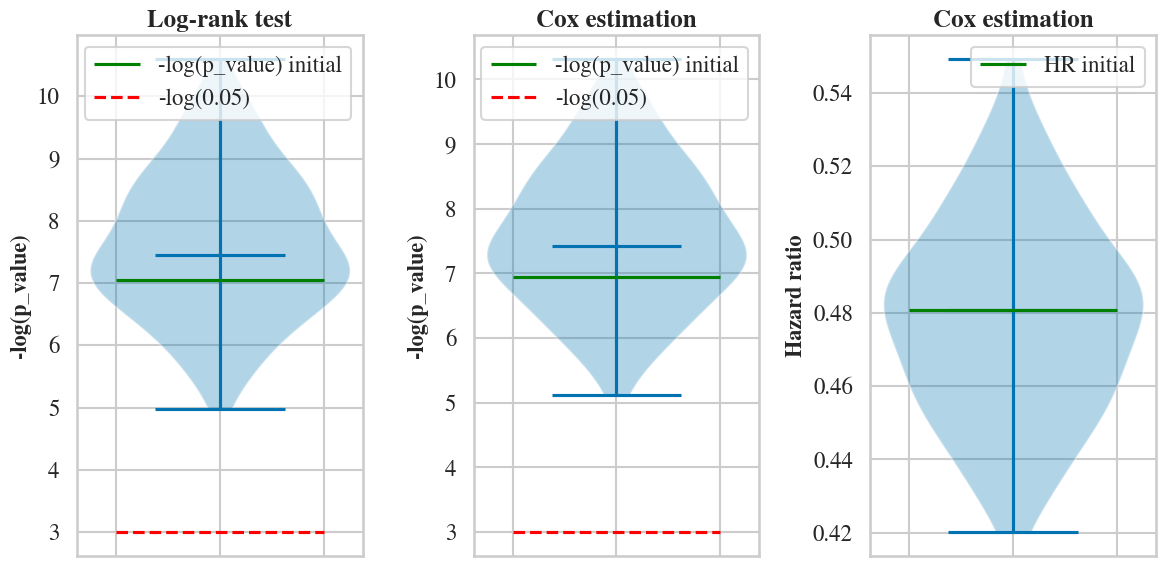

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.2. Stratified testing

#### 4.2.1. Categorical variable

In [20]:
from utils.metrics import strata_log_rank, strata_cox_estimation

# Stratified w.r. karnof analysis
strata_var = 'karnof'
df_init_strata = df_init.copy(deep=True)
df_init_treated_strata = df_init_treated.copy(deep=True)

data_syn_strata = []
for i in range(n_generated_dataset):
    df_gen_control_strata = pd.DataFrame(torch.cat([data_init_control_train, data_gen_control[i]]).numpy(), columns=aids_control_fnames)
    df_gen_control_strata['treatment'] = 0
    data_syn_strata.append(pd.concat([df_init_treated_strata, df_gen_control_strata], ignore_index=True))

strata_LR_init, strata_LR_syn = strata_log_rank(df_init_strata, data_syn_strata, strata=strata_var)
strata_coef_init, strata_coef_syn, strata_cox_p_value_init, strata_cox_p_value_syn = strata_cox_estimation(df_init_strata, data_syn_strata, strata=strata_var)

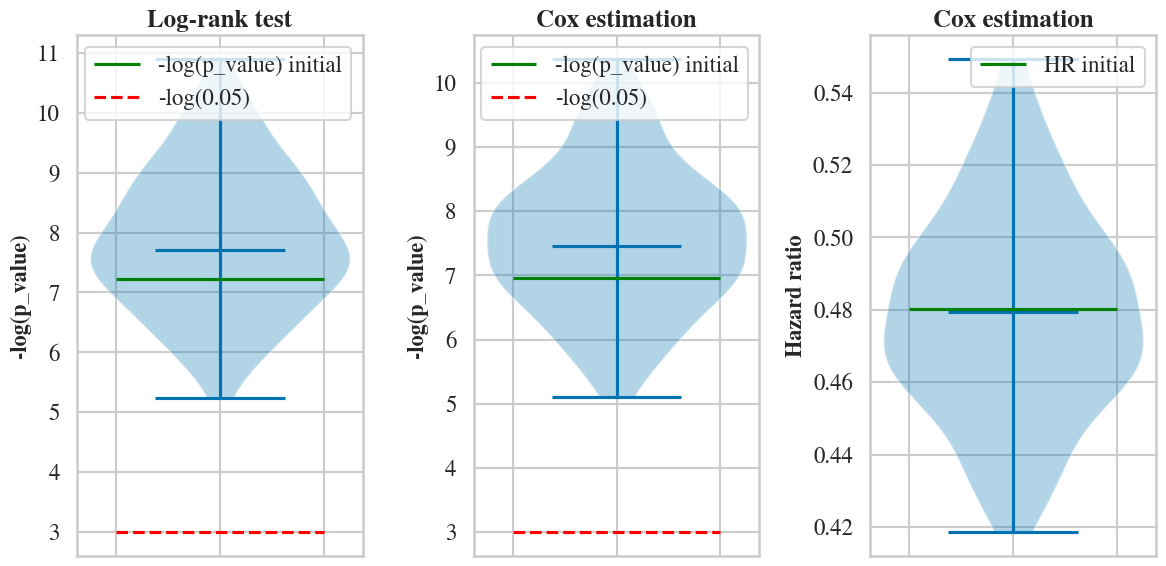

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(strata_LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(strata_LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(strata_cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(strata_cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(strata_coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(strata_coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

#### 4.2.2. Continous variable

In [22]:
# Stratified w.r. CD4 count analysis

# Define the stratified variable
strata_var = 'is_low_cd4'
df_init_strata = df_init.copy(deep=True)
df_init_strata['is_low_cd4'] = (df_init_strata['cd4'] < 50).astype(int)
df_init_treated_strata = df_init_treated.copy(deep=True)
df_init_treated_strata['is_low_cd4'] = (df_init_treated_strata['cd4'] < 50).astype(int)

data_syn_strata = []
for i in range(n_generated_dataset):
    df_gen_control_strata = pd.DataFrame(torch.cat([data_init_control_train, data_gen_control[i]]).numpy(), columns=aids_control_fnames)
    df_gen_control_strata['treatment'] = 0
    df_gen_control_strata['is_low_cd4'] = (df_gen_control_strata['cd4'] < 50).astype(int)
    data_syn_strata.append(pd.concat([df_init_treated_strata, df_gen_control_strata], ignore_index=True))

strata_LR_init, strata_LR_syn = strata_log_rank(df_init_strata, data_syn_strata, strata=strata_var)
strata_coef_init, strata_coef_syn, strata_cox_p_value_init, strata_cox_p_value_syn = strata_cox_estimation(df_init_strata, data_syn_strata, strata=strata_var)

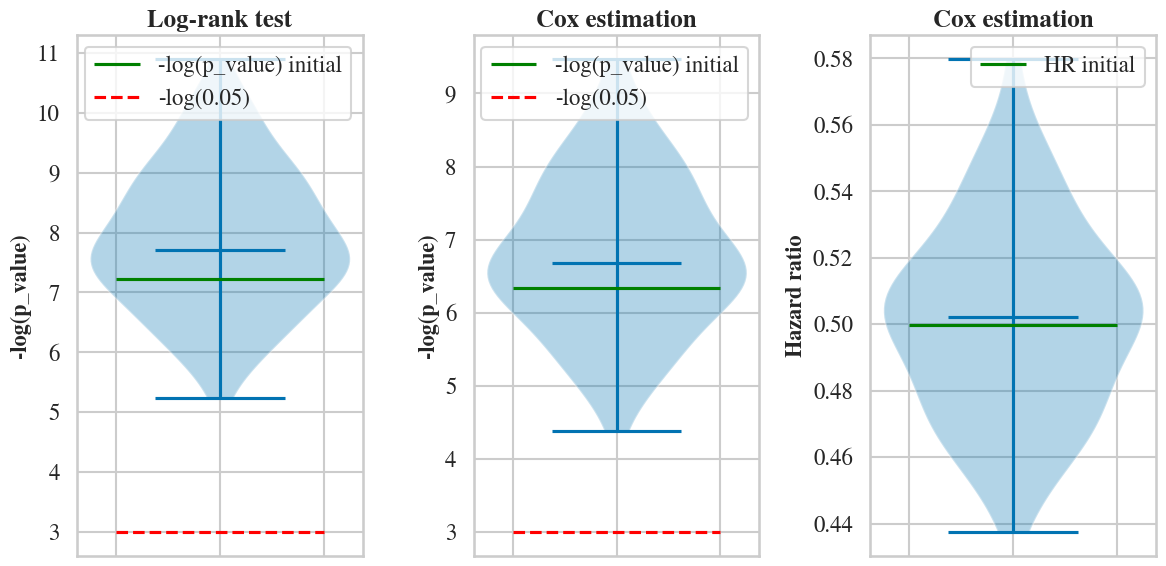

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(strata_LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(strata_LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(strata_cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(strata_cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(strata_coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(strata_coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.3. Metrics form synthcity: initial control data vs. all generated synthetic control groups

In [24]:
# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column

scores = ScoreEvaluator()
for j in range(n_generated_dataset):
    enable_reproducible_results(j)
    clear_cache()

    synthcity_dataloader_syn = SurvivalAnalysisDataLoader(list_df_gen_control[j], 
                                       target_column = "censor", 
                                       time_to_event_column = "time")

    evaluation = Metrics().evaluate(X_gt=synthcity_dataloader_init, # can be dataloaders or dataframes
                                    X_syn=synthcity_dataloader_syn, 
                                    reduction='mean', # default mean
                                    n_histogram_bins=10, # default 10
                                    metrics=None, # all metrics
                                    task_type='survival_analysis', 
                                    use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores.add(key, mean_score[key], errors[key], duration[key], direction[key])

synthcity_score = scores.to_dataframe()
synthcity_score

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
stats.jensenshannon_dist.marginal,0.001292,0.003081,0.002053,0.000312,0.002021,0.000433,100,0,0.01,minimize
stats.chi_squared_test.marginal,0.888518,0.898750,0.894442,0.002237,0.894216,0.003264,100,0,0.00,maximize
stats.inv_kl_divergence.marginal,0.990875,0.992804,0.992117,0.000382,0.992182,0.000426,100,0,0.00,maximize
stats.ks_test.marginal,0.978510,0.988388,0.985023,0.001673,0.984922,0.002080,100,0,0.00,maximize
stats.survival_km_distance.optimism,-0.014386,0.008222,-0.002509,0.004495,-0.002236,0.006446,100,0,0.38,minimize
stats.survival_km_distance.abs_optimism,0.002151,0.015019,0.006914,0.002710,0.006847,0.003876,100,0,0.38,minimize
stats.survival_km_distance.sightedness,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100,0,0.38,minimize
privacy.delta-presence.score,1.250000,2.000000,1.584497,0.203979,1.666667,0.238095,100,0,0.01,maximize
privacy.k-anonymization.gt,2.000000,2.000000,2.000000,0.000000,2.000000,0.000000,100,0,0.02,maximize
privacy.k-anonymization.syn,1.000000,12.000000,5.860000,2.172648,6.000000,3.000000,100,0,0.02,maximize
